# Pittsburgh Neighborhood Safety
> By Jared Peters
---

## Introduction

I chose safety as my metric because it is very important to most people.
No matter why you're in the neighborhood, you want to feel secure.
Here, we will determine the safety of each neighborhood by analyzing recent criminal incidents as well as their relative populations. Essentially, we will find the safest neighborhoods by finding those that are the most dangerous.

## Datasets
- [Police Incident Blotter (30 Day)](https://data.wprdc.org/dataset/police-incident-blotter)
> Information on recent criminal incidents including their location and type
- [Pittsburgh American Community Survey 2015 - Total Population](https://data.wprdc.org/dataset/pittsburgh-american-community-survey-2015-miscellaneous-data/resource/82f29015-6905-4b1c-8300-afe9bb2231b3)
> The most recent and complete data that I could find on neighborhood populations.
> Includes population estimates from 2015.

### Step 1: Setup
- Import pandas and matplotlib
- Import blotter dataframe
- Refine dataset columns

In [1]:
import pandas as pd
# % matplotlib inline

In [2]:
# Import online Blotter data
blotter_data = pd.read_csv("https://data.wprdc.org/datastore/dump/1797ead8-8262-41cc-9099-cbc8a161924b")
blotter_data.columns

Index(['PK', 'CCR', 'HIERARCHY', 'INCIDENTTIME', 'INCIDENTLOCATION',
       'CLEAREDFLAG', 'INCIDENTNEIGHBORHOOD', 'INCIDENTZONE',
       'INCIDENTHIERARCHYDESC', 'OFFENSES', 'INCIDENTTRACT',
       'COUNCIL_DISTRICT', 'PUBLIC_WORKS_DIVISION', 'X', 'Y'],
      dtype='object')

There are many columns, but we only need a few.

In [3]:
# Filter out unnecessary columns
blotter_data = blotter_data[['INCIDENTNEIGHBORHOOD', 'INCIDENTHIERARCHYDESC']]
blotter_data.head(10)

,INCIDENTNEIGHBORHOOD,INCIDENTHIERARCHYDESC
0,Strip District,HIT AND RUN
1,Fineview,99
2,East Hills,THEFT
3,Lincoln-Lemington-Belmar,ENDANGER WELFARE OF CHILDREN
4,Westwood,THEFT BY DECEPTION
5,Squirrel Hill South,CRIM MISCHIEF (GRAFFITI)
6,Banksville,99
7,Perry South,THEFT
8,East Liberty,RETSIL THEFT (SHOPLIFTING)
9,Central Business District,FIREARMS NOT TO BE CARRIED WO LICENSE


### Step 2: Determine Danger Level
- Create a function to weigh incidents based on their severity

There are too many incident types to weight each one

In [4]:
# Count the unique incident types
blotter_data['INCIDENTHIERARCHYDESC'].nunique()

99

We can look at the most common and group them by severity

In [5]:
# Let's take the top 15 and group them into categories for their severity
blotter_data['INCIDENTHIERARCHYDESC'].value_counts().head(20)

99                                559
HIT AND RUN                       293
THEFT                             270
SIMPLE ASSAULT                    168
THEFT FROM AUTO                   147
HARRASSMENT                       132
CRIM MISCHIEF                     117
AIDED CASE                         72
HARRASSMENT/THREAT/ATTEMPT/PHY     62
AGG-ASSAULT                        60
STOLEN PROPERTY - OTHER            60
FOUND PROPERTY                     59
BURGLARY                           58
DEAD ON ARRIVAL (DOA)              48
STOLEN PROPERTY                    45
TERRORISTIC THREATS                45
CRIMINAL MISCHIEF                  44
THEFT BY DECEPTION                 44
MENTAL 201/302                     41
MISCELLANEOUS INVESTIGATION        40
Name: INCIDENTHIERARCHYDESC, dtype: int64

Most of them can be seen as moderate, but some are more minor or severe

In [6]:
severe_incidents = ["BURGLARY", "DEAD ON ARRIVAL (DOA)"]
minor_incidents = ["99", "CRIM MISCHIEF", "RETAIL THEFT (SHOPLIFTING)"]
# Any other incidents will be considered moderate

We'll now make a 'DANGER_LEVEL' column to describe the weighted rating of the offense

In [7]:
def get_incident_weight(incident: str):
    if incident in severe_incidents:
        return 150
    if incident in minor_incidents:
        return 75
    return 100

blotter_data['DANGER_LEVEL'] = blotter_data['INCIDENTHIERARCHYDESC'].map(get_incident_weight)
blotter_data.head()

,INCIDENTNEIGHBORHOOD,INCIDENTHIERARCHYDESC,DANGER_LEVEL
0,Strip District,HIT AND RUN,100
1,Fineview,99,75
2,East Hills,THEFT,100
3,Lincoln-Lemington-Belmar,ENDANGER WELFARE OF CHILDREN,100
4,Westwood,THEFT BY DECEPTION,100


Once we have these danger levels, we can group the data by Neighborhood and aggregate by their total danger level.

In [8]:
nb_groups = blotter_data.groupby('INCIDENTNEIGHBORHOOD')
neighborhood_data = nb_groups.agg({'DANGER_LEVEL':'sum'})
neighborhood_data.head()

,DANGER_LEVEL
INCIDENTNEIGHBORHOOD,
Allegheny Center,2500
Allegheny West,700
Allentown,4175
Arlington,2300
Arlington Heights,350


Here are the top 10 safest and most dangerous neighborhoods, based purely on DANGER_LEVEL

<AxesSubplot:xlabel='Safest Neighborhoods', ylabel='Danger per Capita'>

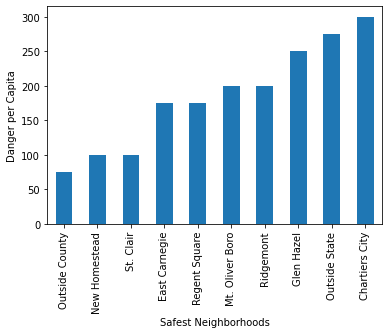

In [9]:
neighborhood_data = neighborhood_data.sort_values(by="DANGER_LEVEL")
neighborhood_data['DANGER_LEVEL'].head(10).plot.bar(xlabel='Safest Neighborhoods', ylabel='Danger per Capita')

<AxesSubplot:xlabel='Most Dangerous Neighborhoods', ylabel='Danger per Capita'>

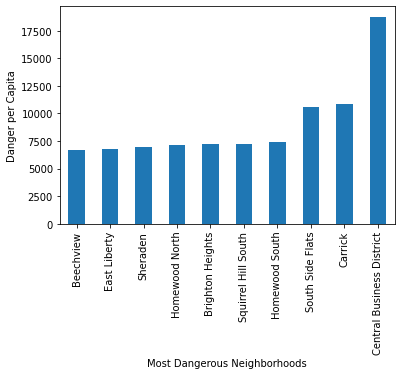

In [10]:
neighborhood_data['DANGER_LEVEL'].tail(10).plot.bar(xlabel="Most Dangerous Neighborhoods", ylabel='Danger per Capita')

## Step 3: Account for Population
This data still may not be a fair indicator, as higher populations will tend to have more crime due to having more people.

We can account for this by importing estimated population data.

In [11]:
population_data = pd.read_csv('https://data.wprdc.org/dataset/5b18c198-474c-4723-b735-cc5220ad43cc/resource/82f29015-6905-4b1c-8300-afe9bb2231b3/download/total-population.csv', index_col='Neighborhood')
population_data.head()

,Id,Estimate; Total,Margin of Error; Total
Neighborhood,,,
Allegheny Center,1,1411.0,196.000000
Allegheny West,2,343.0,96.000000
Allentown,3,2558.0,449.773276
Arlington,4,1852.0,348.188168
Arlington Heights,5,272.0,126.000000


We can add the 'Estimate; Total' data to our current neighborhood data by creating a new column.

In [12]:
neighborhood_data['POPULATION'] = population_data['Estimate; Total']
# Drop any neighborhoods that are missing population data
neighborhood_data = neighborhood_data.dropna()
neighborhood_data.head()

,DANGER_LEVEL,POPULATION
INCIDENTNEIGHBORHOOD,,
New Homestead,100,973.0
St. Clair,100,270.0
East Carnegie,175,610.0
Regent Square,175,1033.0
Ridgemont,200,314.0


Now, we can join our dataframes and create a new column for danger level per capita and sort based on our new values

In [13]:
neighborhood_data['DANGER_PER_CAPITA'] = neighborhood_data['DANGER_LEVEL'] / neighborhood_data['POPULATION']
neighborhood_data = neighborhood_data.sort_values(by="DANGER_PER_CAPITA").dropna()
neighborhood_data.head()

,DANGER_LEVEL,POPULATION,DANGER_PER_CAPITA
INCIDENTNEIGHBORHOOD,,,
New Homestead,100,973.0,0.102775
Regent Square,175,1033.0,0.169409
Squirrel Hill North,2925,11336.0,0.258028
East Carnegie,175,610.0,0.286885
Overbrook,1150,3682.0,0.312330


## Conclusion

This 'DANGER_PER_CAPITA' can be used as our indicator for safety, so let's look at the most and least safe neighborhoods

<AxesSubplot:xlabel='Safest Neighborhoods', ylabel='Danger per Capita'>

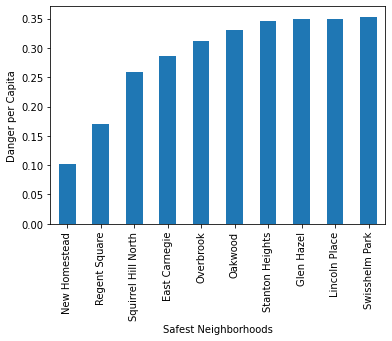

In [14]:
neighborhood_data['DANGER_PER_CAPITA'].head(10).plot.bar(xlabel='Safest Neighborhoods', ylabel='Danger per Capita')

<AxesSubplot:xlabel='Most Dangerous Neighborhoods', ylabel='Danger per Capita'>

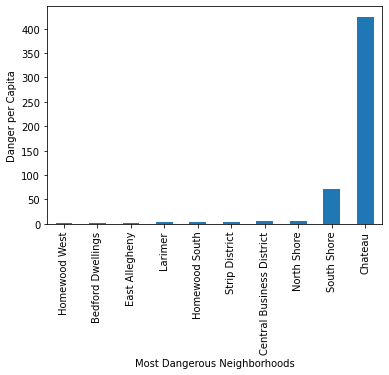

In [15]:
neighborhood_data['DANGER_PER_CAPITA'].tail(10).plot.bar(xlabel="Most Dangerous Neighborhoods", ylabel='Danger per Capita')

### Woah! Why is Chateau's danger rating so high?

![Chateau](https://i.imgur.com/npKt6xa.gif)

Chateau has a very small is population (Only 3, according to our population dataset), and mainly consists of [warehouses](https://en.wikipedia.org/wiki/Chateau_(Pittsburgh)), so it could be possible that people go to this unpopulated neighborhood to stay under the radar and commit crime

In [16]:
neighborhood_data.loc['Chateau']

DANGER_LEVEL         1275.0
POPULATION              3.0
DANGER_PER_CAPITA     425.0
Name: Chateau, dtype: float64

South Shore also similarly has a small population (12) and consists of many warehouses.

In [17]:
neighborhood_data.loc['South Shore']

DANGER_LEVEL         850.000000
POPULATION            12.000000
DANGER_PER_CAPITA     70.833333
Name: South Shore, dtype: float64

Based on calculations including the amount of police incidents reported, the type of incidents, and the neighborhood populations, the final rankings from safest to most dangerous are as follows:

In [18]:
# Print each of the neighborhoods (the index of the df) on separate lines in order
for rank, nb in enumerate(neighborhood_data.index, 1):
    print(f"{rank}. {nb}")

1. New Homestead
2. Regent Square
3. Squirrel Hill North
4. East Carnegie
5. Overbrook
6. Oakwood
7. Stanton Heights
8. Glen Hazel
9. Lincoln Place
10. Swisshelm Park
11. Shadyside
12. St. Clair
13. Greenfield
14. Banksville
15. Squirrel Hill South
16. Bloomfield
17. North Oakland
18. Morningside
19. Brookline
20. Westwood
21. Chartiers City
22. Point Breeze
23. Garfield
24. Spring Garden
25. Highland Park
26. Central Oakland
27. Upper Lawrenceville
28. Mount Washington
29. Ridgemont
30. Lower Lawrenceville
31. Polish Hill
32. Marshall-Shadeland
33. Central Lawrenceville
34. Terrace Village
35. Windgap
36. Duquesne Heights
37. Fairywood
38. Troy Hill
39. Beechview
40. Friendship
41. South Oakland
42. Perry North
43. Upper Hill
44. Summer Hill
45. Spring Hill-City View
46. Crafton Heights
47. Bluff
48. Beltzhoover
49. Brighton Heights
50. Lincoln-Lemington-Belmar
51. South Side Slopes
52. Carrick
53. Elliott
54. Knoxville
55. West Oakland
56. Point Breeze North
57. Sheraden
58. East Lib